In [93]:
# Basic Setup
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

## 1. Gather dataset and preprocess (Ashley)

In [94]:
data = pd.read_csv('data_cpp.csv')
data.head()

,Unnamed: 0,Answer,num_of_lines,code_length,comments,cyclomatic_complexity,num_of_indents,loop_count,line_length,identifiers,readability
0,0,class Solution {\n public:\n vector<int> twoS...,8,347,0,1,4,2,43.375000,8,4.996250
1,1,class Solution {\n public:\n ListNode* addTwo...,12,479,0,3,5,3,39.916667,2,5.727500
2,2,class Solution {\n public:\n int lengthOfLong...,9,303,0,2,3,2,33.666667,6,6.070000
3,3,class Solution {\n public:\n double findMedia...,16,1046,0,4,3,4,65.375000,22,1.496250
4,4,class Solution {\n public:\n string longestPa...,14,916,3,4,9,7,65.428571,14,2.051429


In [95]:
import re
prompt = "{ Please fill in this function }"

def emptyOneFunctionBody(code, firstBrace):
    # Find corresponding }
    numBraces = 1
    i = firstBrace + 1

    # print("------------------------------------------\n Code before Mod:\n" + code)
    # print(i)
    # print("Character found prior to firstBrace: $" + code[i-1] +  code[i] + code[i+1] + "$")

    while i < len(code) and numBraces > 0:
        if code[i] == '{':
            numBraces += 1
        elif code[i] == '}':
            numBraces -= 1
        i += 1
    
    # print("Character found after lastBrace: $" + code[i-1] +  code[i]+ "$\n------------------------------------------\n")
    return code[:firstBrace] + prompt + code[i:], firstBrace + len(prompt)
    

def emptyAllFunctionBodies(code, start):
    # Find first { after first )
    start = max(code.find(')'), start)
    if start < 0:
        return code
    else:
        openBraceLocation = code.find('{', start)
        if openBraceLocation == -1:
            return code
        else:
            newCode, newStart = emptyOneFunctionBody(code, openBraceLocation)
            return emptyAllFunctionBodies(newCode, newStart)
    

In [96]:
# Test function on one coding sample
code_sample = data['Answer'][50]
print(type(code_sample))
print(code_sample + "\n")
code_sample = emptyAllFunctionBodies(code_sample, 0)
print(code_sample)

<class 'str'>
class Solution {
 public:
  vector<vector<string>> solveNQueens(int n) {
    vector<vector<string>> ans;
    dfs(n, 0, vector<bool>(n), vector<bool>(2 * n - 1), vector<bool>(2 * n - 1),
        vector<string>(n, string(n, '.')), ans);
    return ans;
  }

 private:
  void dfs(int n, int i, vector<bool>&& cols, vector<bool>&& diag1,
           vector<bool>&& diag2, vector<string>&& board,
           vector<vector<string>>& ans) {
    if (i == n) {
      ans.push_back(board);
      return;
    }

    for (int j = 0; j < n; ++j) {
      if (cols[j] || diag1[i + j] || diag2[j - i + n - 1])
        continue;
      board[i][j] = 'Q';
      cols[j] = diag1[i + j] = diag2[j - i + n - 1] = true;
      dfs(n, i + 1, move(cols), move(diag1), move(diag2), move(board), ans);
      cols[j] = diag1[i + j] = diag2[j - i + n - 1] = false;
      board[i][j] = '.';
    }
  }
};

class Solution {
 public:
  vector<vector<string>> solveNQueens(int n) { Please fill in this function }

 private

In [97]:
# Duplicate the column Answer
data['Answer_empty'] = data['Answer']

for i in range(17):
    data.loc[i, 'Answer_empty'] = emptyAllFunctionBodies(data.loc[i, 'Answer'], 0)

print(data['Answer'][0])
print("-------------------------------------------------")
print(data['Answer_empty'][0])




class Solution {
 public:
  vector<int> twoSum(vector<int>& nums, int target) {
    unordered_map<int, int> numToIndex;

    for (int i = 0; i < nums.size(); ++i) {
      if (const auto it = numToIndex.find(target - nums[i]);
          it != cend(numToIndex))
        return {it->second, i};
      numToIndex[nums[i]] = i;
    }

    throw;
  }
};
-------------------------------------------------
class Solution {
 public:
  vector<int> twoSum(vector<int>& nums, int target) { Please fill in this function }
};


## 2. Take the emptied code and ask an LLM to fill in the code

## 2.a Run data generation (DONT DO THIS EVERY TIME RUN IT ONCE THEN STORE IT.)

In [98]:
from google import genai
import time

ai_values = [0 for i in range(len(data['Answer_empty']))]
data['ai_generated'] = ai_values

data.to_csv('data_cpp_human.csv', index=False)

# create a dummy dataframe to store the AI generated code until we concatenate w/ original dataframe
ai_data = pd.DataFrame(columns = data.columns)

# USE YOUR OWN API TOKEN/KEY HERE for API access, we're using Gemini 2.0 Flash model
client = genai.Client(api_key="PUT_API_TOKEN_HERE")

# This is the number of requests you can make per minute, adjust as needed
requests_per_minute = 15

## Loop through the data and generate AI code wherever it says "Please fill in this function".
for i,code in enumerate(data['Answer_empty']):
    request = client.models.generate_content(
        model="gemini-2.0-flash", contents="In the following code snippet, give the C++ implementation where it says \"Please fill in this function\" in the appropriate C++ implementation. Do not generate additional text.\n" + data['Answer_empty'][0],
    )
    ## check if it included markdown syntax
    generated_code = request.text
    if "```cpp" in generated_code:
        generated_code = generated_code.split("```cpp")[1].split("```")[0]

    response = code.replace("Please fill in this function", generated_code)
    
    ## Calculate the number of lines, code length, comments, num of indents, loop count, avg line length, identifiers, readability
    num_of_lines = len(response.split("\n"))
    code_length = len(response)
    comments = len(re.findall(r'//', response)) + (len(re.findall(r'/\*', response)) + len(re.findall(r'\*/', response))) // 2
    num_indents = len(re.findall(r'\t', response)) + len(re.findall(r'    ', response))
    loop_count = len(re.findall(r'for', response)) + len(re.findall(r'while', response))
    avg_line_length = code_length / num_of_lines
    identifiers = len(re.findall(r'\b\w+\b', response)) / num_of_lines
    readability = 0.39 * avg_line_length + 0.1 * num_indents + 0.15 * comments + 0.2 * loop_count + 0.16 * identifiers
    
    ## put the data in a new row, and append it to the dummy dataframe
    new_row = [i, response, num_of_lines,  code_length,  comments, 0, num_indents,  loop_count,  avg_line_length,  identifiers, readability, None, 1]
    ai_data = pd.concat([ai_data, pd.DataFrame([new_row], columns=ai_data.columns)], ignore_index=True)
    time.sleep(60 / requests_per_minute * 1.1)

ai_data.to_csv('data_cpp_ai.csv', index=False)

ImportError: cannot import name 'genai' from 'google' (unknown location)

## 2.b After you have generated AI code data, read it and merge with human sample data.

In [ ]:
## Try to read the data from the csv file, if it exists
try:
    data_ai = pd.read_csv('data_cpp_ai.csv')
    data_human = pd.read_csv('data_cpp.csv')
except:
    print("One or more data files not found. Please make sure the data file is in the same directory as this script. or run the data generation script first.")
    ## create a new column to store the AI generated code, initialize existing code as human generated
## initialize the 
data_human['ai_generated'] = 0

data_human.to_csv('data_cpp_human.csv', index=False)

## drop weird indexing column and intermediate column for empty function headers
data_ai.drop(columns=['Unnamed: 0', "Answer_empty"], inplace=True)
## drop weird indexing column
data_human.drop(columns=['Unnamed: 0'], inplace=True)

data_combined = pd.concat([data_human, data_ai], ignore_index=True)

## saved the combined data to a file so we don't have to redo this entire process again
data_combined.to_csv('data_cpp_combined.csv', index=False)

## 3. Use a large codebase repository to train a Doc2Vec model to be used in converting programming language code into a vector embedding for the model

In order to avoid the issue of giving the model code with sections/ngrams that it hasn't seen before, you would want to train it on a sufficiently large corpus of potential text to capture data beyond your dataset.
In our case, 

In [ ]:
import gensim

# Create corpus from code samples
documents = data_combined['Answer']


## 4. Encode code samples into vector embeddings and construct the data table to be passed to the model.

Alternative idea, use the new Google Gemini API based embedding!

## 5. Tokenize all code (Word2Vec) and create features for our ML model to use

## 6. Run ML models (ex: Random Forest (RF), XGBoost, and Support Vector Machine (SVM) ) (Muntaka)

In [141]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [133]:
df = pd.DataFrame(data_combined)
# print(df.head(5))

In [134]:
num_rows = df[df['ai_generated'] == 1].shape[0]
print(num_rows)

1504


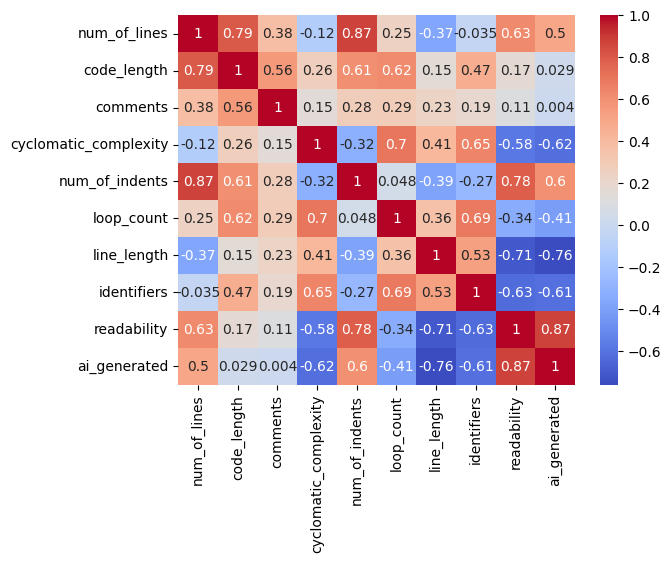

In [135]:
corr_matrix = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [136]:
# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# X = df.drop(columns=['ai_generated'])
X = df.drop(columns=['ai_generated', 'readability', 'line_length'])
y = df['ai_generated']

# Handle categorical columns (if any exist)
if X.select_dtypes(include=['object']).shape[1] > 0:
    X = pd.get_dummies(X, drop_first=True)  # One-hot encoding for categorical features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#### Random Forest Classifier

In [137]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

val_preds = rf_model.predict(X_val_scaled) 
test_preds = rf_model.predict(X_test_scaled)  

val_acc = accuracy_score(y_val, val_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"Random Forest Validation Accuracy: {val_acc:.2f}")
print(f"Random Forest Test Accuracy: {test_acc:.2f}")

Random Forest Validation Accuracy: 0.99
Random Forest Test Accuracy: 1.00


#### XGBoost Classifier

In [138]:
param_grid = {
    'eta': [0.01, 0.05, 0.07, 0.1],
    'max_depth': [1, 3, 5, 7],
    'min_child_weight': [1, 2, 5],
    'n_estimators': [50, 100, 200],
    'objective': ['binary:logistic'],
    'eval_metric': ['logloss']
}
xgb_model = xgb.XGBClassifier()

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold Cross Validation
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# best_xgb = xgb.XGBClassifier(**best_params)
best_xgb = xgb.XGBClassifier(
    **best_params,
    gamma=0.3,  # Add regularization
    subsample=0.8,  # Use only 80% of training data per tree
    colsample_bytree=0.8  # Use 80% of features per tree
)
best_xgb.fit(X_train_scaled, y_train)

val_preds = best_xgb.predict(X_val_scaled)
val_acc = accuracy_score(y_val, val_preds)
print(f"XGBoost Validation Accuracy: {val_acc:.2f}")

conf_matrix = confusion_matrix(y_val, val_preds)
print("Confusion Matrix (Validation Set):")
print(conf_matrix)

test_preds = best_xgb.predict(X_test_scaled)
test_acc = accuracy_score(y_test, test_preds)
print(f"XGBoost Test Accuracy: {test_acc:.2f}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/Users/ibnathism/Documents/Winter25/AI/AI-Project/CS205AIGeneratedCode/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'eta': 0.07, 'eval_metric': 'logloss', 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'binary:logistic'}
XGBoost Validation Accuracy: 1.00
Confusion Matrix (Validation Set):
[[199   0]
 [  2 220]]
XGBoost Test Accuracy: 1.00


#### Support vector machine(SVM)

In [139]:
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)

svm_preds = svm_model.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, svm_preds)
print(f"SVM Accuracy (Default): {svm_acc:.2f}")

# Hyperparameter Tuning with GridSearchCV (Regularization parameter 'C' and Kernel coefficient 'gamma')
param_grid = {
    'C': [0.1, 1, 10, 100],  
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  
    'kernel': ['rbf']
}

grid_search = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold Cross Validation
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
print(f"Best Parameters for SVM: {best_params}")

best_svm = SVC(**best_params, random_state=42)
best_svm.fit(X_train_scaled, y_train)
test_preds_svm = best_svm.predict(X_test_scaled)
test_acc_svm = accuracy_score(y_test, test_preds_svm)
print(f"SVM Test Accuracy (Best Model): {test_acc_svm:.2f}")

conf_matrix_svm = confusion_matrix(y_test, test_preds_svm)
print("Confusion Matrix (SVM Test Set):")
print(conf_matrix_svm)


SVM Accuracy (Default): 0.50
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/ibnathism/Documents/Winter25/AI/AI-Project/CS205AIGeneratedCode/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters for SVM: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Test Accuracy (Best Model): 0.90
Confusion Matrix (SVM Test Set):
[[426  42]
 [ 48 387]]


## 7. Gather precision, recall, accuracy, and f1-score for each model (Muntaka)

In [142]:
# Evaluate XGBoost Model
xgb_preds_test = best_xgb.predict(X_test_scaled)
xgb_report = classification_report(y_test, xgb_preds_test, digits=4)
xgb_acc = accuracy_score(y_test, xgb_preds_test)

print("XGBoost Model Evaluation:")
print(f"Accuracy: {xgb_acc:.4f}")
print(xgb_report)

# Evaluate SVM Model
svm_preds_test = best_svm.predict(X_test_scaled)
svm_report = classification_report(y_test, svm_preds_test, digits=4)
svm_acc = accuracy_score(y_test, svm_preds_test)

print("SVM Model Evaluation:")
print(f"Accuracy: {svm_acc:.4f}")
print(svm_report)


XGBoost Model Evaluation:
Accuracy: 0.9989
              precision    recall  f1-score   support

           0     1.0000    0.9979    0.9989       468
           1     0.9977    1.0000    0.9989       435

    accuracy                         0.9989       903
   macro avg     0.9989    0.9989    0.9989       903
weighted avg     0.9989    0.9989    0.9989       903

SVM Model Evaluation:
Accuracy: 0.9003
              precision    recall  f1-score   support

           0     0.8987    0.9103    0.9045       468
           1     0.9021    0.8897    0.8958       435

    accuracy                         0.9003       903
   macro avg     0.9004    0.9000    0.9001       903
weighted avg     0.9004    0.9003    0.9003       903

